In [ ]:
DBFILE = "allblocks-parity_run7.db"
NAME_PREFIX="parity-aura_run7"  

# analyze `____.db` data

calculates & plots

* blocktime
* TPS (transactions per second), over 1, 3, 5, 10 consecutive blocks
* block size
* gasUsed and gasLimit per second

It needs an `allblocks-....db` database (created by `blocksDB_create.py`) containing all the blocks.

---

Please cite this as:

> Ethereum benchmarking scripts "chainhammer" and "chainreader"  
> by Dr Andreas Krueger, Electron.org.uk, London 2018  
> https://github.com/drandreaskrueger/chainhammer    

Consider to submit your improvements & usage as pull request --> [../other-projects.md](../other-projects.md).  Thanks.


---

<a id='chainhammer1000'>20000 transactions shot at a node</a>
# my own experiment: 
## 20000 transactions submitted with `chainhammer` 


    


## TOC

Code 

* [import from database](#Database)
* [simple statistics](#stats)
* [generate new columns](#columns)
* [4 diagrams in one](#code4diagrams)

Results

* [tables of peak TPS rates](#tables)
* [all 3 consecutive experiments](#allExperiments)
* [experiment 1](#experiment 1)
* [experiment 3](#experiment 3)


<a id='database'>Database</a>

In [ ]:
#dependencies

import sqlite3; print("sqlite3 version", sqlite3.version)
import pandas; print("pandas version", pandas.__version__)
import numpy; print("numpy version", numpy.__version__)
import matplotlib; print("matplotlib version", matplotlib.__version__)

%matplotlib inline

# https://github.com/matplotlib/matplotlib/issues/5907#issuecomment-179001811
matplotlib.rcParams['agg.path.chunksize'] = 10000

# my own routines:
from blocksDB_diagramming import DB_query, DB_tableSize, maxBlockNumber, check_whether_complete
from blocksDB_diagramming import add_blocktime, add_TPS, add_GUPS, add_GLPS

print ("\nReading blocks table from", DBFILE)

sqlite3 version 2.6.0
pandas version 0.23.0
numpy version 1.14.4
matplotlib version 2.2.2

Reading blocks table from allblocks-parity_run7.db


<a id='stats'>simple statistics</a>
### some simple statistics

In [ ]:
# open database connection
conn = sqlite3.connect(DBFILE)

print ("DB table names: ", DB_query("SELECT name FROM sqlite_master WHERE type='table';", conn)[0])

# number of rows?
_=DB_tableSize("blocks", conn)

# what is the first & last block we have?
minblock, maxblock = maxBlockNumber(conn)[0]

blocknumbers = DB_query("SELECT blocknumber FROM blocks ORDER BY blocknumber", conn) 
print ("len(blocknumbers)=", len(blocknumbers))

# do we have consecutive blocks, none missing?
check_whether_complete(blocknumbers)

DB table names:  ('blocks',)
TABLE blocks has 91 rows
MIN(blocknumber), MAX(blocknumber) = [(0, 90)] 
len(blocknumbers)= 91

complete between blocks 0 and 90.


In [ ]:
# simple statistics

size_max = DB_query("SELECT MAX(size) FROM blocks", conn); print ("(block)size_max", size_max[0][0])
txcount_max = DB_query("SELECT MAX(txcount) FROM blocks", conn); print ("txcount_max", txcount_max[0][0])
txcount_av = DB_query("SELECT AVG(txcount) FROM blocks", conn); print ("txcount_av", txcount_av[0][0])
txcount_sum = DB_query("SELECT SUM(txcount) FROM blocks", conn); print ("txcount_sum", txcount_sum[0][0])
blocks_nonempty_count = DB_query("SELECT COUNT(blocknumber) FROM blocks WHERE txcount != 0", conn); print ("blocks_nonempty_count", blocks_nonempty_count[0][0])
print ("av tx per nonempty blocks = ", txcount_sum[0][0] / blocks_nonempty_count[0][0] )

(block)size_max 162956
txcount_max 1194
txcount_av 219.8131868131868
txcount_sum 20003
blocks_nonempty_count 84
av tx per nonempty blocks =  238.13095238095238


<a id='colums'>new columns</a>
## read whole table, and create new columns

In [ ]:
# read whole table

# SQL="SELECT * FROM blocks WHERE 48500<blocknumber and blocknumber<49000 ORDER BY blocknumber"
SQL="SELECT * FROM blocks ORDER BY blocknumber"
df = pandas.read_sql(SQL, conn)

In [ ]:
conn.close()

### `geth` based clients have a nanosecond timestamp

not anymore?

In [ ]:
# transform nanoseconds to seconds
# df["timestamp"]=df["timestamp"]/1000000000
df[0:5]


,blocknumber,timestamp,size,gasUsed,gasLimit,txcount
0,0,0,534,0,40000000,0
1,1,1536057340,974,127173,40000000,1
2,2,1536057344,714,41691,40000000,1
3,3,1536057366,974,127173,40000000,1
4,4,1536057370,5540,1002567,40000000,37


In [ ]:
# blocktime = timestamp[n] - timestamp[n-1]
add_blocktime(df)


#df["TPS_1"]=df['txcount']/df['blocktime']
#df


# transactions per second
# with differently sized (rectangular) windows
add_TPS(df, numBlocks=1)
add_TPS(df, numBlocks=3)
add_TPS(df, numBlocks=5)
add_TPS(df, numBlocks=10)


# gasUsed and gasLimit per second
add_GUPS(df, numBlocks=1)
add_GUPS(df, numBlocks=3)
add_GUPS(df, numBlocks=5)

add_GLPS(df, numBlocks=1)
add_GLPS(df, numBlocks=3)
add_GLPS(df, numBlocks=5)

<a id='tables'>tables of peak TPS rates</a>
## peak TPS rates

In [ ]:
# peak TPS single block

df.sort_values(by=['TPS_1blk'], ascending=False)[0:10]

,blocknumber,timestamp,size,gasUsed,gasLimit,txcount,blocktime,TPS_1blk,TPS_3blks,TPS_5blks,TPS_10blks,GUPS_1blk,GUPS_3blks,GUPS_5blks,GLPS_1blk,GLPS_3blks,GLPS_5blks
37,37,1536057496,105297,20552070,40000000,770,2.0,385.00,81.083333,65.458333,76.142857,10276035.00,2164195.25,1.747148e+06,20000000.0,10000000.0,8.333333e+06
32,32,1536057472,162956,31869054,40000000,1194,4.0,298.50,142.100000,90.388889,65.250000,7967263.50,3792791.10,2.412570e+06,10000000.0,12000000.0,1.111111e+07
22,22,1536057432,76333,14866887,40000000,557,2.0,278.50,95.700000,75.388889,71.833333,7433443.50,2554328.70,2.012205e+06,20000000.0,12000000.0,1.111111e+07
67,67,1536057616,122565,23941827,40000000,897,4.0,224.25,109.700000,74.850000,65.050000,5985456.75,2928002.70,1.997821e+06,10000000.0,12000000.0,1.000000e+07
79,79,1536057656,58513,11370366,40000000,426,2.0,213.00,77.800000,65.750000,66.125000,5685183.00,2076559.80,1.754933e+06,20000000.0,12000000.0,1.250000e+07
55,55,1536057568,51441,9982434,40000000,374,2.0,187.00,66.250000,65.312500,65.575000,4991217.00,1768278.75,1.743256e+06,20000000.0,15000000.0,1.250000e+07
72,72,1536057632,42326,8194137,40000000,307,2.0,153.50,66.250000,66.437500,71.111111,4097068.50,1768278.75,1.773283e+06,20000000.0,15000000.0,1.250000e+07
15,15,1536057408,83129,16201437,40000000,607,4.0,151.75,83.916667,75.650000,74.583333,4050359.25,2239819.75,2.019174e+06,10000000.0,10000000.0,1.000000e+07
45,45,1536057528,82857,16148055,40000000,605,4.0,151.25,83.750000,76.000000,74.789474,4037013.75,2235371.25,2.028516e+06,10000000.0,10000000.0,1.000000e+07
59,59,1536057584,70754,13772556,40000000,516,4.0,129.00,81.833333,78.500000,70.722222,3443139.00,2184213.50,2.095244e+06,10000000.0,10000000.0,1.111111e+07


In [ ]:
# peak TPS over ten blocks

df.sort_values(by=['TPS_10blks'], ascending=False)[0:10]

,blocknumber,timestamp,size,gasUsed,gasLimit,txcount,blocktime,TPS_1blk,TPS_3blks,TPS_5blks,TPS_10blks,GUPS_1blk,GUPS_3blks,GUPS_5blks,GLPS_1blk,GLPS_3blks,GLPS_5blks
41,41,1536057512,67086,13051899,40000000,489,4.0,122.25,82.916667,100.444444,86.431818,3262974.75,2213128.75,2.680963e+06,10000000.0,1.000000e+07,1.111111e+07
40,40,1536057508,5478,960876,40000000,36,4.0,9.00,45.750000,73.444444,83.666667,240219.00,1221113.25,1.960306e+06,10000000.0,1.000000e+07,1.111111e+07
39,39,1536057504,64495,12544770,40000000,470,4.0,117.50,128.300000,74.300000,83.452381,3136192.50,3424455.30,1.983141e+06,10000000.0,1.200000e+07,1.000000e+07
76,76,1536057646,27777,5338200,40000000,200,2.0,100.00,78.800000,69.687500,81.411765,2669100.00,2103250.80,1.860029e+06,20000000.0,1.200000e+07,1.250000e+07
75,75,1536057644,10644,1975134,40000000,74,4.0,18.50,50.666667,69.687500,81.264706,493783.50,1352344.00,1.860029e+06,10000000.0,1.000000e+07,1.250000e+07
46,46,1536057536,71569,13932702,40000000,522,8.0,65.25,94.785714,64.708333,80.023810,1741587.75,2529925.50,1.727130e+06,5000000.0,8.571429e+06,8.333333e+06
74,74,1536057640,70484,13719174,40000000,514,4.0,128.50,84.100000,66.500000,79.235294,3429793.50,2244713.10,1.774952e+06,10000000.0,1.200000e+07,1.250000e+07
38,38,1536057500,6429,1147713,40000000,43,4.0,10.75,81.600000,54.100000,77.023810,286928.25,2177985.60,1.443983e+06,10000000.0,1.200000e+07,1.000000e+07
37,37,1536057496,105297,20552070,40000000,770,2.0,385.00,81.083333,65.458333,76.142857,10276035.00,2164195.25,1.747148e+06,20000000.0,1.000000e+07,8.333333e+06
24,24,1536057440,63136,12277860,40000000,460,4.0,115.00,108.000000,82.222222,75.250000,3069465.00,2882628.00,2.194593e+06,10000000.0,1.200000e+07,1.111111e+07


<a id='code4diagrams'>code: 4 diagrams in one</a>
## all 4 diagrams in one

TODO - once this routine is also ready, move it out into `blocksDB_diagramming.py`   
but at the moment this is still in flux

In [ ]:
def diagrams(df, blockFrom, blockTo, prefix="", gas_logy=True, bt_logy=True):
    
    # https://github.com/matplotlib/matplotlib/issues/5907#issuecomment-179001811
    matplotlib.rcParams['agg.path.chunksize'] = 10000
    
    # prepare 2x2 subplots
    plt = matplotlib.pyplot
    fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15,10))
    plt.tight_layout(pad=6.0, w_pad=6.0, h_pad=7.5)
    title = prefix + " blocks %d to %d" % (blockFrom, blockTo)
    plt.suptitle(title, fontsize=16)
    
    # bar charts are too expensive when too many blocks
    numBlocks =  blockTo - blockFrom
    kind = 'bar' if numBlocks<2000 else 'line'
    
    # TPS averages --> legend
    cols=['TPS_1blk', 'TPS_3blks', 'TPS_5blks', 'TPS_10blks']
    averages=df[cols][blockFrom:blockTo].mean()
    legend = [col + " (av %.1f)" % averages[col] for col in cols]
    # print (legend)
    
    # TPS diagram
    cols = ['blocknumber'] + cols
    ax=df[cols][blockFrom:blockTo].plot(x='blocknumber', rot=90, ax=axes[0,0])
    ax.set_title("transactions per second")
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    ax.legend(legend);
    
    # BT
    ax=df[['blocknumber', 'blocktime']][blockFrom:blockTo].plot(x='blocknumber', kind=kind, ax=axes[0,1],
                                                               logy=bt_logy)
    ax.set_title("blocktime since last block")
    ax.locator_params(nbins=1, axis='x')  # TODO: Something is broken with matplotlib's ticks machinery
        
    # blocksize
    ax=df[['blocknumber', 'size']][blockFrom:blockTo].plot(x='blocknumber', rot=90, kind=kind, ax=axes[1,0])
    # ax.get_xaxis().get_major_formatter().set_useOffset(False)
    ax.get_yaxis().get_major_formatter().set_scientific(False)
    ax.set_title("blocksize in bytes")
    ax.locator_params(nbins=1, axis='x')  # TODO: Something is broken with matplotlib's ticks machinery
    
    # gas
    ax=df[['blocknumber', 'GLPS_1blk', 'GUPS_1blk']][blockFrom:blockTo].plot(x='blocknumber', 
                                                                             rot=90, ax=axes[1,1], 
                                                                             logy=gas_logy)
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    if not gas_logy:
        ax.get_yaxis().get_major_formatter().set_scientific(False)
    ax.set_title("gasUsed and gasLimit per second")
    
    # save diagram to PNG file
    fig.savefig("img/%s_tps-bt-bs-gas_blks%d-%d.png" % (prefix,blockFrom,blockTo))


# <a id='allExperiments'>whole chain</a>


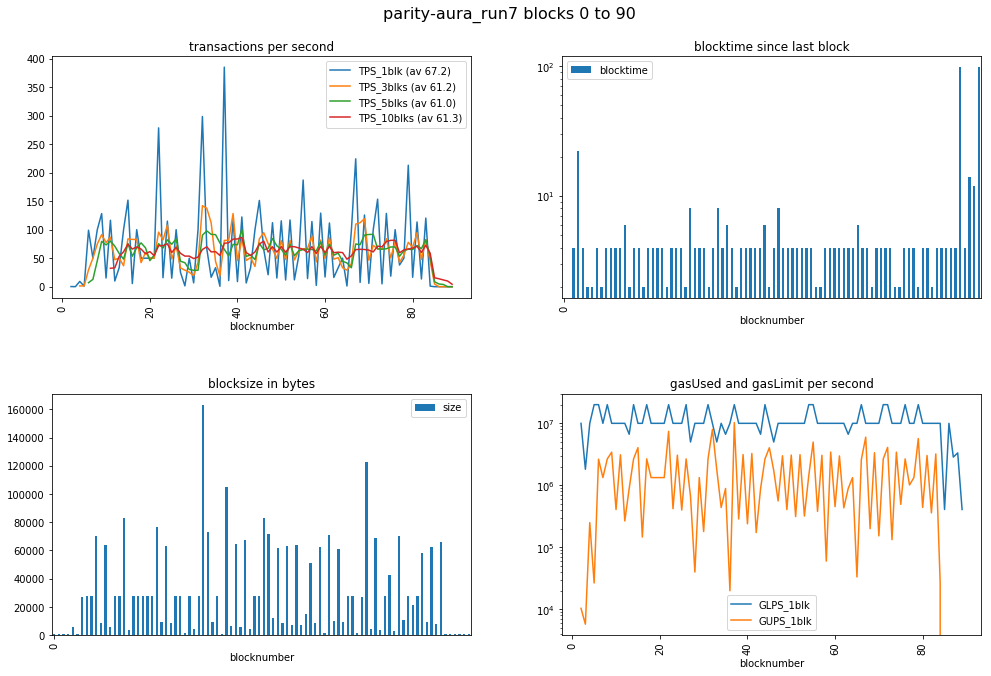

In [ ]:
# the whole range of blocks

diagrams(df, 0, len(blocknumbers)-1, NAME_PREFIX, gas_logy=True, bt_logy=True)

<a id='experiment1'>zoom in on one experiment</a>

# zooming in ...


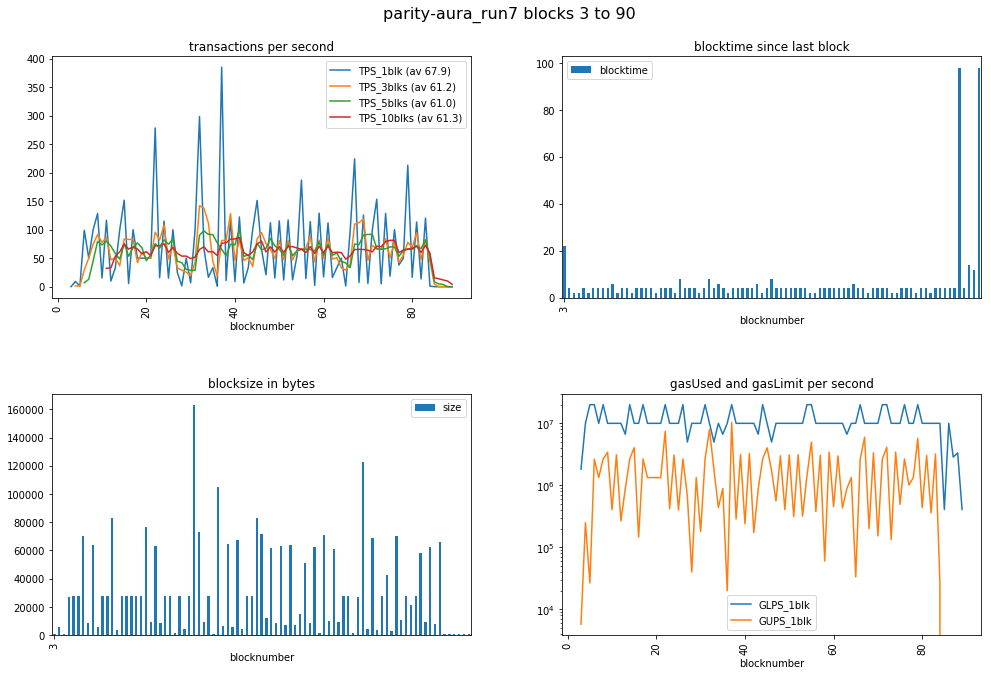

In [ ]:
# starting only at block xx because the waiting time before experiment start

diagrams(df, 3,90, NAME_PREFIX, gas_logy=True, bt_logy=False)